In [1]:
import os
from datetime import timedelta
import sys

In [2]:
########################### Parameters to adjust ##########################################################################################

destination = None # Available options : 'ifremer',
make_lagrangian_diags = True # True or False
draw_L3 = True

dir_massh = '/bettik/PROJECTS/pr-data-ocean/stellaa/MASSH/mapping'
path_config = './config_EUREC4A_REANALYSIS.py' 

name_experiment: EUREC4A_REANALYSIS
saveoutputs: True
name_exp_save: EUREC4A_REANALYSIS
path_save: ./output_EUREC4A_REANALYSIS/20200220/
tmp_DA_path: ./scratch/EUREC4A_REANALYSIS
init_date: 2020-01-20 00:00:00
final_date: 2020-02-20 00:00:00
assimilation_time_step: 3:00:00
saveoutput_time_step: 3:00:00
flag_plot: 0
write_obs: False
path_obs: ./scratch/EUREC4A_REANALYSIS
name_lon: lon
name_lat: lat
name_time: time
plot_time_step: 1 day, 0:00:00
time_obs_min: None
time_obs_max: None
compute_obs: False

NAME_OBSOP is not set in the configuration file
NAME_BASIS is not set in the configuration file
NAME_DIAG is not set in the configuration file


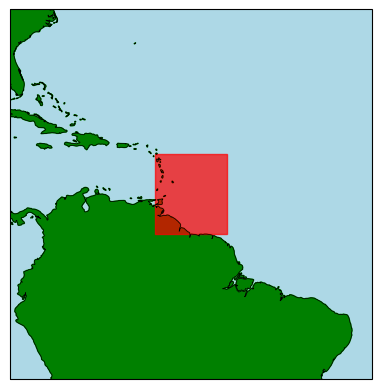

In [3]:
###########################################################################################################################################
###  0. INITIALIZATION
###########################################################################################################################################

sys.path.append(dir_massh)
currdir=os.getcwd()

from src import exp
config = exp.Exp(path_config)
name_experiment = config.EXP.name_experiment
today = config.EXP.final_date
numdays = int((today-config.EXP.init_date)/timedelta(days = 1))

lon_min = config.GRID.lon_min                            
lon_max = config.GRID.lon_max                               
lat_min = config.GRID.lat_min                                 
lat_max = config.GRID.lat_max
bbox = [lon_min, lon_max, lat_min, lat_max]   

from tools.plot_tools import where_is_this
where_is_this(bbox, 20)

In [ ]:
###########################################################################################################################################
###  1. DATA DOWNLOAD
###########################################################################################################################################

from tools.ftp_transfer import download_nadirs_cmems, download_swot_nadir
from tools.remapping import make_mdt

# What datasets to download
datasets = [
    'dataset-duacs-nrt-global-al-phy-l3', 
    'dataset-duacs-nrt-global-c2n-phy-l3', 
    'dataset-duacs-nrt-global-h2b-phy-l3',
    'dataset-duacs-nrt-global-s3a-phy-l3',
    'dataset-duacs-nrt-global-s3b-phy-l3',
    'cmems_obs-sl_glo_phy-ssh_nrt_j3n-l3-duacs_PT1S',
    'cmems_obs-sl_glo_phy-ssh_nrt_s6a-hr-l3-duacs_PT1S',
]

dataset_l4 = 'dataset-duacs-nrt-global-merged-allsat-phy-l4'

# FTP connection to CMEMS server and observational data download
download_nadirs_cmems(name_experiment, currdir, today, numdays, datasets, dataset_l4)
download_swot_nadir(name_experiment, currdir, today)

In [ ]:
# If needed, download and properly formats mdt file
make_mdt(name_experiment, currdir,bbox)

In [ ]:
############################################################################################################################################
### 2. BOUNDARY CONDITIONS
############################################################################################################################################

from tools.remapping import compute_filled_map

# Rework DUACS dataset for optimal boundary conditions : extrapolate data to fill coasts. 
# Then a mask is used in MASSH to select only ocean and avoid awkward 0 values around coasts
BC_data_path = currdir+'/input_'+name_experiment+'/'+today.strftime('%Y%m%d')+'/dataset-duacs-nrt-global-merged-allsat-phy-l4/*.nc'
save_new_BC_to = currdir+'/input_'+name_experiment+'/'+today.strftime('%Y%m%d')+'/duacs_l4_filled.nc'

compute_filled_map(BC_data_path, save_new_BC_to, bbox)

In [ ]:
############################################################################################################################################
### 3. DATA ASSIMILATION WITH MASSH (BFN-QG)
############################################################################################################################################

# State
from src import state as state
State = state.State(config)

# Obs
from src import obs as obs # if no files to open, re-download data
dict_obs = obs.Obs(config,State)

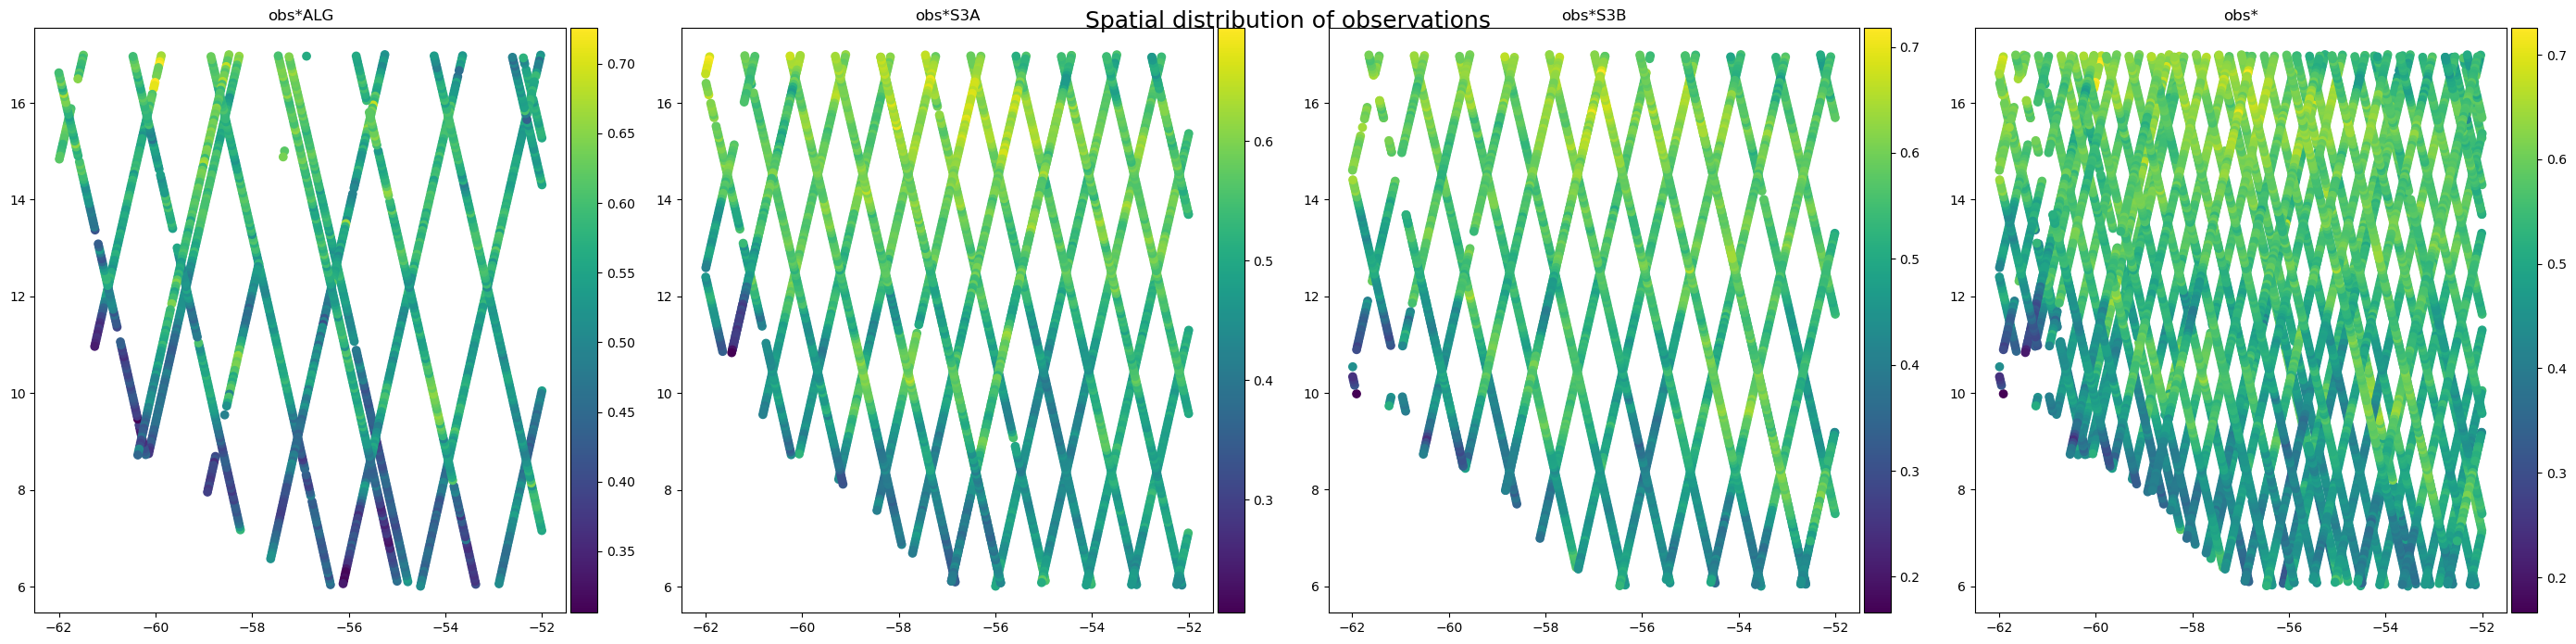

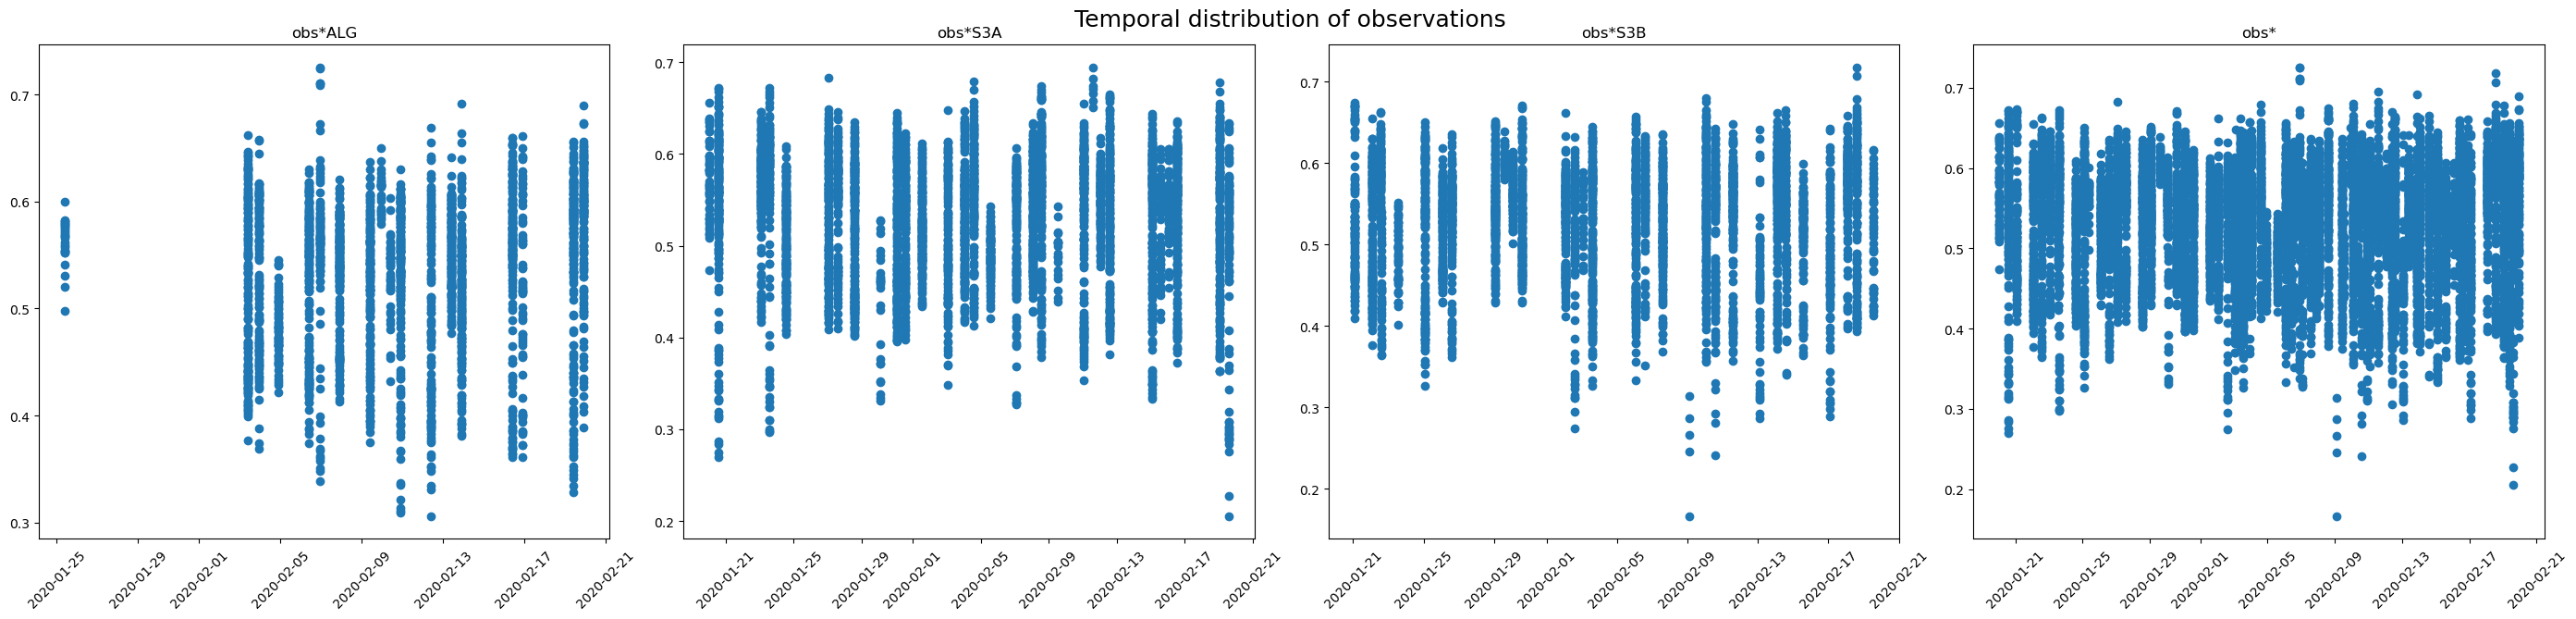

In [4]:
if draw_L3 == True:
    from tools.plot_tools import plot_l3_data
    l3_datasets = [
        'obs*ALG',
        'obs*S3A',
        'obs*S3B',
        'obs*'
    ]
    plot_l3_data(bbox, l3_datasets, today, numdays, name_experiment)

In [ ]:
# Model
from src import mod as mod
Model = mod.Model(config,State)

# Bondary Conditions
from src import bc as bc
Bc = bc.Bc(config)

# Inversion
from src import inv as inv
inv.Inv(config,State,Model,dict_obs=dict_obs,Bc=Bc)

In [ ]:
###########################################################################################################################################
### 4. RESULTS PROCESSING
###########################################################################################################################################

from tools.remapping import nc_processing
nc_processing(name_experiment, today=today)

In [ ]:
#######################################################################################
### 5. LAMTA LAGRANGIAN DIAGNOSTICS
#######################################################################################

if make_lagrangian_diags == True:
    dir_lamta = '/bettik/PROJECTS/pr-data-ocean/stellaa/lamtaLR'
    from tools.remapping import apply_lamta
    lamta_diags_results = apply_lamta(name_experiment, currdir, dir_lamta, today, bbox, numdays=30, bathylvl =-500)

In [ ]:
###########################################################################################################################################
### 6. MAPS UPLOAD
###########################################################################################################################################
# Here, choose the right function to send to the right place. 

if destination == 'ifremer':
    from tools.ftp_transfer import ftp_to_ifremer
    ftp_to_ifremer(name_experiment, today, currdir)